# Census Income
---

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer

#### Import the data file

In [2]:
raw_df = pd.read_csv('files/datasets/adult.csv')
raw_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Because values from the CSV file in Kaggle uses `?` as null values, we will replace those question marks with a NaN. 

In [3]:
raw_df.replace(to_replace='?', value=np.nan, inplace=True)

In [4]:
raw_df.replace(to_replace='<=50K', value=0, inplace=True)
raw_df.replace(to_replace='>50K', value=1, inplace=True)

#### View information about the dataframe

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


#### Split the data into target and features

In [6]:
def xy_split(dataframe, y_column):
    features = dataframe.loc[:, dataframe.columns != y_column]
    target = dataframe[y_column]
    return features, target

X, y = xy_split(raw_df, 'income')

#### Create training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Create a copy of the original dataset

In [8]:
df = X_train.copy()

---

# Data Preparation

#### Import necesary libraries

In [9]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn import set_config
set_config(transform_output="pandas")

#### Determine which columns have low cardinality

In [10]:
def ohe_eligibility(datafame):
    for i in datafame.columns:
        if len(datafame[i].value_counts()) < 10:
            print(f'{len(datafame[i].value_counts())} - {i}')
        else:
            pass
        
ohe_eligibility(df)

8 - workclass
7 - marital.status
6 - relationship
5 - race
2 - sex


### Fixing/Encoding Marital Status column

In [11]:
df['marital.status'].value_counts(dropna=False)

Married-civ-spouse       11977
Never-married             8502
Divorced                  3582
Separated                  827
Widowed                    790
Married-spouse-absent      352
Married-AF-spouse           18
Name: marital.status, dtype: int64

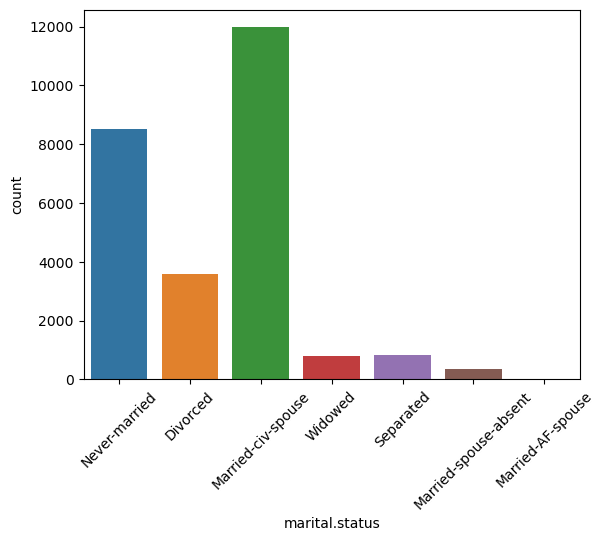

In [12]:
sns.countplot(x='marital.status', data=df)
plt.xticks(rotation=45)
plt.show()

Reduce categories by merging different categories into one.

Single: **Never Married**

Break: **Divorced**, **Widowed**, **Separated**

Married: **Married-civ-spouse**, **Married-spouse-absent**, **Married AF spouse**

In [13]:
replacements_dict = {"Never-married": "single", 
                     "Divorced": "break", 
                     "Separated": "break",
                     "Widowed": "break", 
                     "Married-civ-spouse": "married",
                     "Married-spouse-absent": "married", 
                     "Married-AF-spouse": "married",}

In [14]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer

# Define a custom function to replace a value in a dataframe
def replace_values(dataframe, column, replacements_dict):
    dataframe[column] = dataframe[column].replace(replacements_dict)
    return dataframe

# Create a FunctionTransformer object
replace_transformer = FunctionTransformer(replace_values, kw_args={'column': 'marital.status', 'replacements_dict': replacements_dict})

# # Apply the transformer to a example dataframe
df_new = replace_transformer.transform(df)

In [15]:
df_new.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
5514,26,Private,256263,HS-grad,9,single,Craft-repair,Not-in-family,White,Male,0,0,25,United-States
19777,24,Private,170277,HS-grad,9,single,Other-service,Not-in-family,White,Female,0,0,35,United-States
10781,36,Private,75826,Bachelors,13,break,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32240,22,State-gov,24395,Some-college,10,married,Adm-clerical,Wife,White,Female,0,0,20,United-States
9876,31,Local-gov,356689,Bachelors,13,married,Prof-specialty,Husband,White,Male,0,0,40,United-States


In [16]:
df_new['marital.status'].value_counts()

married    12347
single      8502
break       5199
Name: marital.status, dtype: int64

In [17]:
# Apply One-Hot Encoding

ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [18]:
ct = make_column_transformer(
    (ohe_enc, ['marital.status']))

In [19]:
ms_enc = ct.fit_transform(df_new)

In [20]:
ms_enc.head()

,onehotencoder__marital.status_break,onehotencoder__marital.status_married,onehotencoder__marital.status_single
5514,0.0,0.0,1.0
19777,0.0,0.0,1.0
10781,1.0,0.0,0.0
32240,0.0,1.0,0.0
9876,0.0,1.0,0.0


----

### Fixing Workclass column

In [21]:
df['workclass'].value_counts(dropna=False)

Private             18153
Self-emp-not-inc     2032
Local-gov            1680
NaN                  1436
State-gov            1062
Self-emp-inc          901
Federal-gov           766
Without-pay            12
Never-worked            6
Name: workclass, dtype: int64

Let's merge the categorical varaibles to reduce cardinality

In [22]:
replacements_dict_wc = {"Private": "P.Employed", 
                        "Self-emp-not-inc": "S.Employed", 
                        "Local-gov": "G.Employed",
                        "State-gov": "G.Employed", 
                        "Self-emp-inc": "S.Employed",
                        "Federal-gov": "G.Employed", 
                        "Without-pay": "P.Employed",
                        "Never-worked": "Unemployed"}

Private          - P.Employed         <br>
Self-emp-not-inc - S.Employed      <br>
Local-gov        - G.Employed       <br>
NaN              - NaN                <br>
State-gov        - G.Employed       <br>
Self-emp-inc     - S.Employed      <br>
Federal-gov      - G.Employed       <br>
Without-pay      - P.Employed           <br>
Never-worked     - Unemployed         <br>

In [23]:
raw_df_copy = raw_df.copy()

wc_df = replace_values(raw_df_copy, 'workclass', replacements_dict_wc)

In [24]:
wc_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,P.Employed,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,P.Employed,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,P.Employed,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [25]:
wc_df['workclass'].value_counts(dropna=False)

P.Employed    22710
G.Employed     4351
S.Employed     3657
NaN            1836
Unemployed        7
Name: workclass, dtype: int64

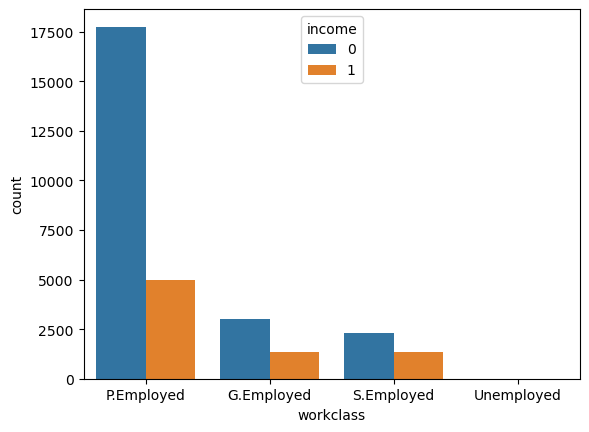

In [26]:
# Determine how workclass and income are nested
sns.countplot(x = 'workclass', 
              hue = 'income', 
              data = wc_df)
 
# Show the plot
plt.show()

In [27]:
# Use as a transformer

replace_transformer_wc = FunctionTransformer(replace_values, kw_args={'column': 'workclass', 'replacements_dict': replacements_dict_wc})

### Fixing Relationship column (NA)

In [28]:
wc_df['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

```
parent       - Husband        - husband sa kanyang family    <br>
no_family    - Not-in-family  - walang fam    <br>
no_family    - Own-child      - child sa kanyang fam    <br>
no_family    -Unmarried      - walang fam    <br>
parent       - Wife           - husband sa kanyang family    <br>
no_family    - Other-relative - walang fam    <br>

```

In [29]:
replacements_dict_r = {"Husband": "parent",           
                       "Not-in-family": "no_family",      
                       "Own-child": "no_family",   
                       "Unmarried": "no_family",  
                       "Wife": "parent",      
                       "Other-relative": "no_family"}

In [30]:
r_df = replace_values(wc_df, 'relationship', replacements_dict_r)

In [31]:
r_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,no_family,White,Female,0,4356,40,United-States,0
1,82,P.Employed,132870,HS-grad,9,Widowed,Exec-managerial,no_family,White,Female,0,4356,18,United-States,0
2,66,NaN,186061,Some-college,10,Widowed,NaN,no_family,Black,Female,0,4356,40,United-States,0
3,54,P.Employed,140359,7th-8th,4,Divorced,Machine-op-inspct,no_family,White,Female,0,3900,40,United-States,0
4,41,P.Employed,264663,Some-college,10,Separated,Prof-specialty,no_family,White,Female,0,3900,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,P.Employed,310152,Some-college,10,Never-married,Protective-serv,no_family,White,Male,0,0,40,United-States,0
32557,27,P.Employed,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,parent,White,Female,0,0,38,United-States,0
32558,40,P.Employed,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,parent,White,Male,0,0,40,United-States,1
32559,58,P.Employed,151910,HS-grad,9,Widowed,Adm-clerical,no_family,White,Female,0,0,40,United-States,0


In [32]:
replace_transformer_r = FunctionTransformer(replace_values, kw_args={'column': 'relationship', 'replacements_dict': replacements_dict_r})

---

### Fixing Occupation column (NA)

Let's try to impute this using columns from other data, we wil discover if it is possible to impute the `occupation` based on sex, race, education and workclass.

In [33]:
wc_df['occupation'].value_counts(dropna=False)

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
NaN                  1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [34]:
hs_grads = wc_df.loc[wc_df['education.num'] == 10]

In [35]:
hs_grads.loc[hs_grads['occupation'].isna()]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
2,66,NaN,186061,Some-college,10,Widowed,NaN,no_family,Black,Female,0,4356,40,United-States,0
48,68,NaN,192052,Some-college,10,Married-civ-spouse,NaN,parent,White,Female,0,2457,40,United-States,0
49,67,NaN,174995,Some-college,10,Married-civ-spouse,NaN,parent,White,Male,0,2457,40,United-States,0
320,21,NaN,40052,Some-college,10,Never-married,NaN,no_family,White,Male,0,2001,45,United-States,0
739,28,NaN,123147,Some-college,10,Married-civ-spouse,NaN,parent,White,Female,0,1887,40,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32303,20,NaN,99891,Some-college,10,Never-married,NaN,no_family,White,Female,0,0,30,United-States,0
32319,59,NaN,120617,Some-college,10,Never-married,NaN,no_family,Black,Female,0,0,40,United-States,0
32335,21,NaN,205939,Some-college,10,Never-married,NaN,no_family,White,Male,0,0,40,United-States,0
32338,18,Unemployed,153663,Some-college,10,Never-married,NaN,no_family,White,Male,0,0,4,United-States,0


In [36]:
hs_grads['occupation'].value_counts()

Adm-clerical         1281
Sales                1009
Exec-managerial       879
Craft-repair          868
Other-service         781
Prof-specialty        430
Machine-op-inspct     310
Transport-moving      283
Tech-support          273
Handlers-cleaners     267
Protective-serv       202
Farming-fishing       174
Priv-house-serv        16
Armed-Forces            2
Name: occupation, dtype: int64

## Decision Tree as Imputer

In [37]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [38]:
# Split the data into features and target variable
X = data.drop('target', axis=1)
y = data['target']

NameError: name 'data' is not defined

In [ ]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Impute missing values in the training set
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Train the DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train_imputed, y_train)

# Impute missing values in the test set
X_test_imputed = imputer.transform(X_test)

# Predict the target values for the test set
y_pred = clf.predict(X_test_imputed)

# Evaluate the model's performance
print("Accuracy:", clf.score(X_test_imputed, y_test))

In [ ]:
not_null = wc_df[['age','workclass']][wc_df['occupation'].notnull()]

In [ ]:
wc_df[['age','workclass', 'education']][wc_df['occupation'].notnull()]

In [ ]:
raw_df_copy['marital.status'].value_counts()

In [ ]:
# Determine how workclass and income are nested
sns.countplot(x = 'relationship', 
              hue = 'income', 
              data = wc_df)
 
# Show the plot
plt.show()

### Fixing Race column (NA)

In [ ]:
wc_df['race'].value_counts(dropna=False)

In [ ]:
# Determine how workclass and income are nested
sns.countplot(x = 'race', 
              hue = 'income', 
              data = wc_df)
 
# Show the plot
plt.show()

In [ ]:
# Apply KNNImputing or MICE

In [ ]:
df['relationship'].value_counts(dropna=False)

Ano kinalaman neto?!

#### Explore KNNImputing

In [ ]:
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ms_pipe = make_pipeline(replace_transformer, ohe_enc)

In [ ]:
count_process = ColumnTransformer([ 
    ('ohe', ohe_enc, ['relationship', 'sex']), 
    ('repl_tf', ms_pipe, ['marital.status'])
])

In [ ]:
count_process.fit_transform(df)

### Next Task 

* How to apply FunctionTransformer inside a pipeline

* [ ] Age
* [ ] workclass
* [ ] fnlwght
* [ ] education
* [ ] education.num
* [X] martial.status
* [ ] occupation
* [X] relationship
* [ ] race
* [X] sex
* [ ] occupation
* [ ] capital.gain
* [ ] capital.loss
* [ ] hours.per.week
* [ ] native.country
* [ ] income

---

In [ ]:
freq_imp = SimpleImputer(strategy="most_frequent")
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipeline = make_pipeline(freq_imp, ohe_enc)

In [ ]:
from category_encoders import CountEncoder

cnt_encoder = CountEncoder()

ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cardinality_pipeline = make_pipeline(freq_imp, cnt_encoder)

In [ ]:
df.columns

In [ ]:
oe = OrdinalEncoder()

In [ ]:
count_process = ColumnTransformer([
    ('count', cardinality_pipeline, ['relationship', 'marital.status']),
    ('ohe', ohe_enc, ['sex'])
])

In [ ]:
df['workclass'].isnull().sum()

In [ ]:
count_process.fit_transform(df)

----

In [ ]:
df

---

---